In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import osmnx as ox
from functools import partial
import numpy as np
import pandas as pd
from multiprocessing import Pool,cpu_count
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import MultiLineString,MultiPoint,Point,LineString,MultiPolygon
from shapely import wkt
from shapely.ops import nearest_points
import glob
import time
import gpxpy
from itertools import groupby
import random
import sklearn
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
from lib_garmin_elevation import *

0.05597209930419922


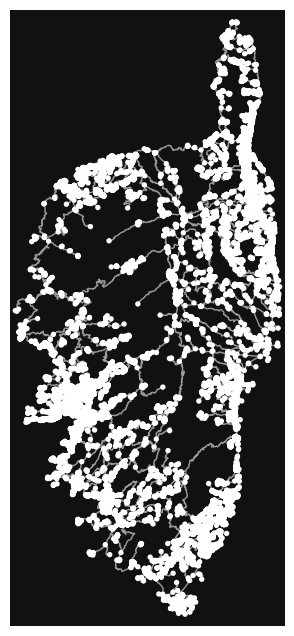

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
place_name='Corse, France'
G_osm_dir=ox.graph_from_place(place_name,network_type='drive')
G_osm=to_multi_graph(G_osm_dir)
crs=ox.graph_to_gdfs(G_osm,edges=False).estimate_utm_crs()
G_osm=ox.project_graph(G_osm,to_crs=crs)
t1=time.time()
add_missing_geometries(G_osm)
t2=time.time()
print(t2-t1)

ox.plot_graph(G_osm)


In [3]:
def parallelized_preprocess(file_paths):
    garmin_dfs=[preprocess(file_path,G_osm,crs=crs) for file_path in file_paths]
    return pd.concat(garmin_dfs)

In [4]:
GENERATE=True
navigation_df_path='/home/pierre/Documents/navigation_df.csv'
if GENERATE:
    t1=time.time()
    nb_cpu=cpu_count()-1
    file_paths=glob.glob('/home/pierre/Documents/garmin_corse/*.gpx')
    chunked_file_paths=chunk(file_paths,nb_cpu)
    with Pool(nb_cpu) as p:
        navigation_dfs=p.map(parallelized_preprocess,chunked_file_paths)
    navigation_df=pd.concat(navigation_dfs)
    navigation_df=navigation_df.to_crs('epsg:4326')
    navigation_df.to_csv(navigation_df_path,index=False)
    navigation_df=navigation_df.to_crs(crs)
    t2=time.time()
    print(t2-t1)
else:
    navigation_df=pd.read_csv(navigation_df_path)
    navigation_df['geometry']=navigation_df['geometry'].apply(wkt.loads)
    navigation_df=gpd.GeoDataFrame(navigation_df,geometry='geometry',crs='epsg:4326')
    navigation_df['time']=pd.to_datetime(navigation_df['time'])
    navigation_df['edge']=navigation_df['edge'].apply(eval)
    navigation_df=navigation_df.to_crs(crs)
navigation_df

reading file took 0.902357 s
estimating crs took 0.020897 s
reading file took 1.146092 sreading file took 1.149770 s
reading file took 1.153682 s

estimating crs took 0.024590 sestimating crs took 0.020614 sestimating crs took 0.024943 s


reading file took 2.506805 s
estimating crs took 0.034084 s
reading file took 2.888249 s
estimating crs took 0.045110 s
reading file took 3.012617 s
estimating crs took 0.033661 s
projecting took  2.032484 s
projecting took  2.088369 sprojecting took  2.085521 s

projecting took  2.347893 s
adding segments took 0.246738 s
adding segments took 0.279728 s
adding segments took 0.399588 s
reading file took 0.155714 s
estimating crs took 0.017328 sadding segments took 0.588599 s

reading file took 0.649035 s
estimating crs took 0.037317 s
reading file took 0.895082 s
estimating crs took 0.015220 s
projecting took  0.727091 s
adding segments took 0.234874 s
reading file took 0.722522 s
estimating crs took 0.024868 s
projecting took  1.511672 s
projecting t

,file_path,geometry,elevation,time,edge,edge_coordinate,pre_segment,orientation,segment
0,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482452.154 4710449.517),8.200000,2023-09-05 13:57:31+00:00,"(51319395, 9064150112, 0)",406.639341,0,1.0,0
1,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482455.064 4710445.288),30.200001,2023-09-05 13:57:32+00:00,"(51319395, 9064150112, 0)",411.773043,0,1.0,0
2,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482458.498 4710440.297),32.400002,2023-09-05 13:57:33+00:00,"(51319395, 9064150112, 0)",417.831396,0,1.0,0
3,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482461.864 4710435.404),33.000000,2023-09-05 13:57:34+00:00,"(51319395, 9064150112, 0)",423.769641,0,1.0,0
4,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482464.925 4710430.956),33.400002,2023-09-05 13:57:35+00:00,"(51319395, 9064150112, 0)",429.169124,0,1.0,0
...,...,...,...,...,...,...,...,...,...
14392,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482312.549 4710652.407),69.000000,2021-04-01 14:31:34+00:00,"(51319395, 9064150112, 0)",160.359109,44,-1.0,83
14393,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482311.203 4710654.365),70.000000,2021-04-01 14:31:35+00:00,"(51319395, 9064150112, 0)",157.983103,44,-1.0,83
14394,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482310.766 4710655.000),70.000000,2021-04-01 14:31:36+00:00,"(51319395, 9064150112, 0)",157.212514,44,-1.0,83
14395,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482311.316 4710654.200),70.000000,2021-04-01 14:31:37+00:00,"(51319395, 9064150112, 0)",158.183261,44,1.0,84


In [5]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
G_navigation=build_multidigraph(G_osm,navigation_df)
t2=time.time()
print(t2-t1)


6.878932952880859


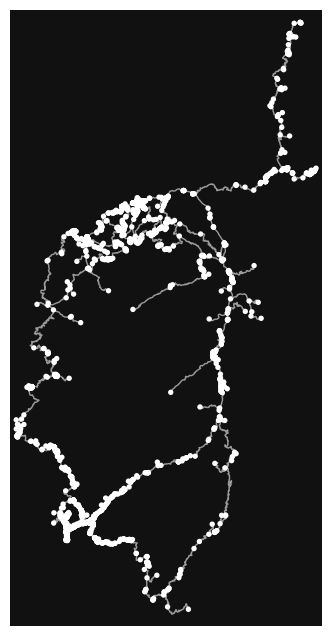

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
edges=sorted(navigation_df['edge'].unique(),key=lambda edge:G_osm.get_edge_data(*edge)['length'])
ox.plot_graph(nx.edge_subgraph(G_osm,edges))

0.10498666763305664


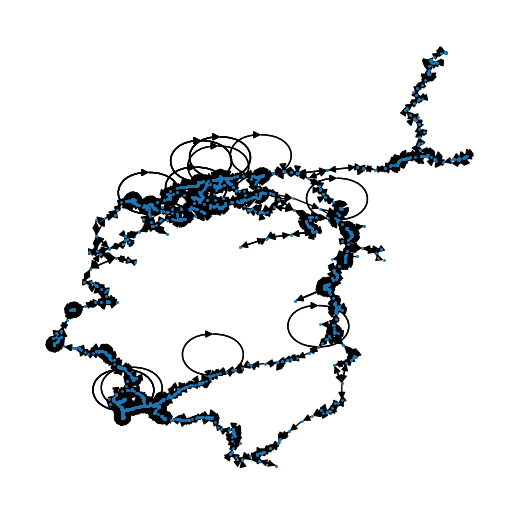

In [7]:
plt.rcParams['figure.figsize']=(5,5)
t1=time.time()
dual_G=build_dual_graph(G_navigation)
t2=time.time()
print(t2-t1)
pos={edge:(G_navigation.nodes()[edge[0]]['x']+G_navigation.nodes()[edge[1]]['x'],G_navigation.nodes()[edge[0]]['y']+G_navigation.nodes()[edge[1]]['y']) for edge in dual_G.nodes()}
nx.draw(dual_G,pos=pos,node_size=1)

0.5080749988555908


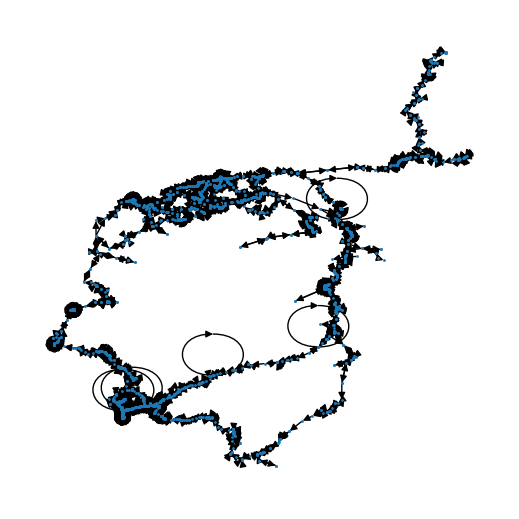

In [9]:
t1=time.time()
dual_tree=build_dual_tree(dual_G)
t2=time.time()
print(t2-t1)
pos={edge:(G_navigation.nodes()[edge[0]]['x']+G_navigation.nodes()[edge[1]]['x'],G_navigation.nodes()[edge[0]]['y']+G_navigation.nodes()[edge[1]]['y']) for edge in dual_G.nodes()}
nx.draw(dual_tree,pos=pos,node_size=1)

In [15]:
t1=time.time()
paths=graph_decomposition(dual_tree)
t2=time.time()
print(t2-t1)
len(paths)

0.6379120349884033


570

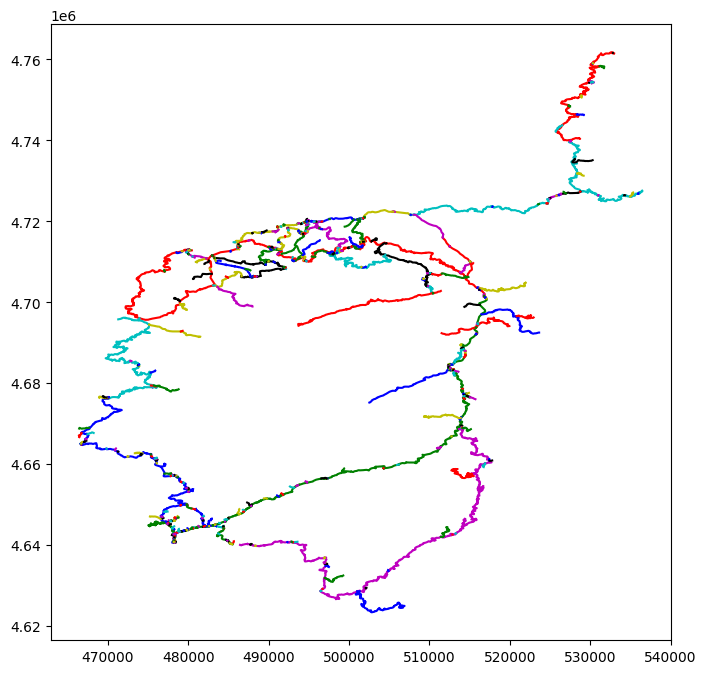

In [16]:
colors=['r','g','b','y','k','m','c']
for k,path in enumerate(paths[:]):
    for edge in path:
        data=G_osm.get_edge_data(*edge)
        if data is None:
            data=G_osm.get_edge_data(edge[1],edge[0],edge[2])
        ls=data['geometry']
        coords=np.array(ls.coords)
        plt.plot(coords[:,0],coords[:,1],c=colors[k%len(colors)])

In [17]:
path=paths[0]
len(path)

103

0.04763364791870117


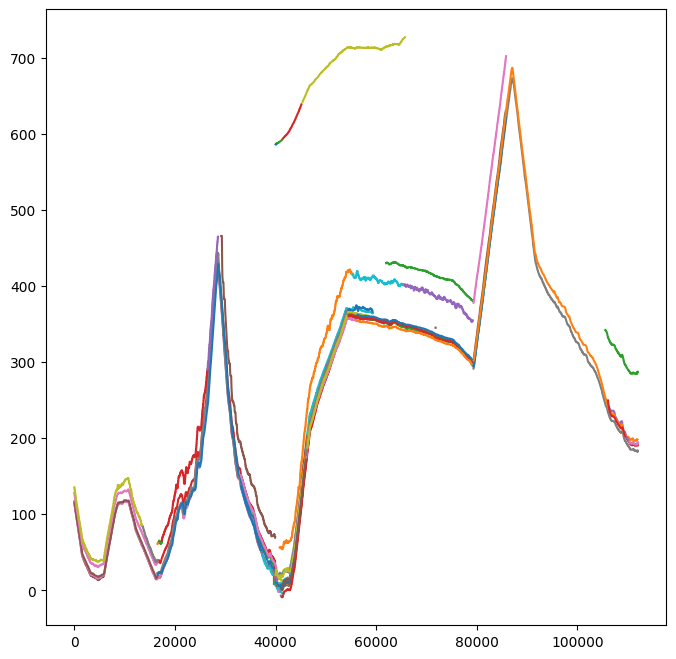

In [37]:
plt.rcParams['figure.figsize']=(8,8)


t1=time.time()
meta_segments,nodes_positions=get_meta_segments_along_path(path,G_navigation,G_osm)
t2=time.time()
print(t2-t1)
for elem in meta_segments:
    X,Y=elem['X'],elem['Y']
    plt.plot(X,Y)



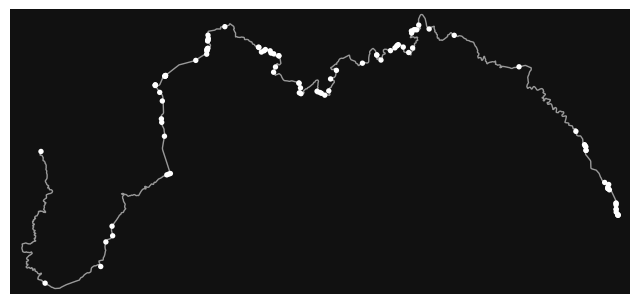

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [38]:
ox.plot_graph(nx.edge_subgraph(G_osm_dir,map(tuple,path[:])))

1.2389304637908936 4.44279408454895


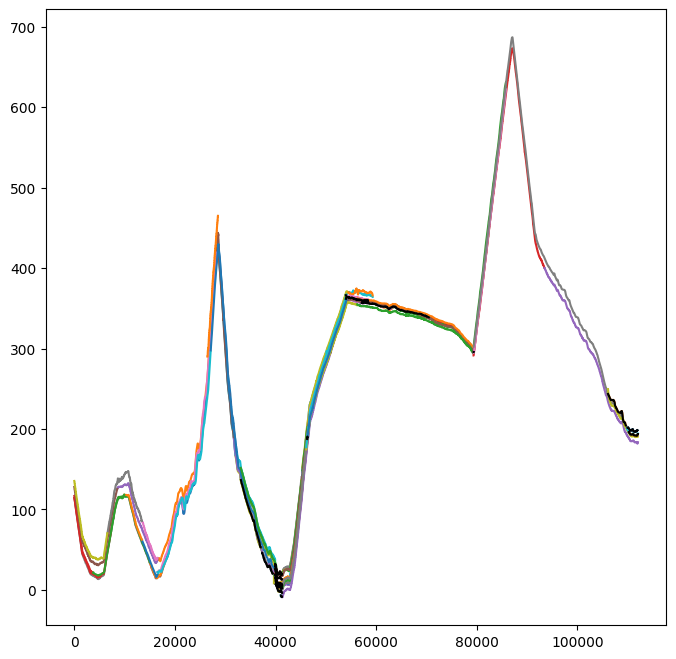

In [39]:
plt.rcParams['figure.figsize']=(8,8)
t1=time.time()
meta_segments=split_meta_segments(meta_segments,max_delta_T=900)
meta_segments=harmonize_meta_segments(meta_segments)
meta_segments=discard_outliers(meta_segments)
t2=time.time()
pairwise_shifts,affine_meta_segments=get_pairwise_shifts(meta_segments,overlay_threshold=0.25,)
t3=time.time()
print(t3-t2,t2-t1)
for meta_segment in meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])
for k in affine_meta_segments:
    meta_segment=meta_segments[k]
    plt.plot(meta_segment['X'],meta_segment['Y'],c='k')    

0.0032281875610351562


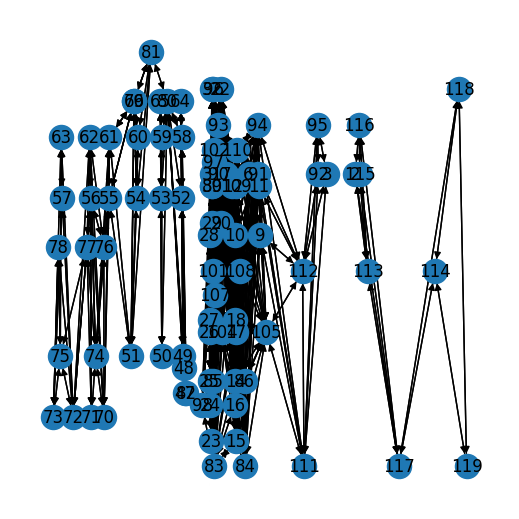

In [40]:
plt.rcParams['figure.figsize']=(5,5)

file_paths=list(np.unique(navigation_df['file_path']))
N=len(meta_segments)
t1=time.time()
shift_G=get_shifts_graph(pairwise_shifts,correlation_treshold=0.99)
t2=time.time()
print(t2-t1)

pos={k:(np.mean(meta_segments[k]['X']),file_paths.index(meta_segments[k]['file_path'])) for k in range(N)} 
nx.draw(shift_G,pos=pos,with_labels=True)

0.0030019283294677734


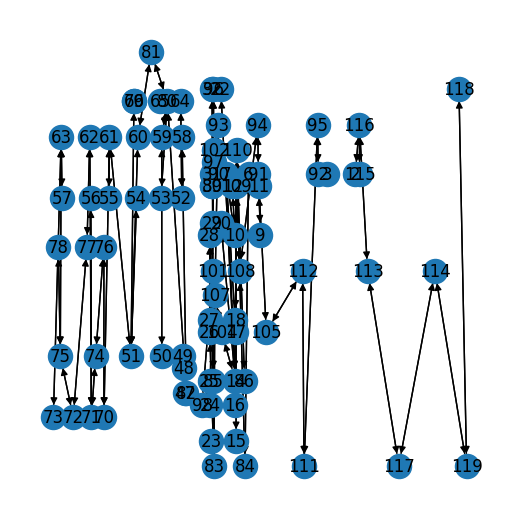

In [41]:
t1=time.time()
tree_edges=list(nx.minimum_spanning_edges(nx.Graph(shift_G),weight='weight',data=False))
tree_edges+=[(v,u) for u,v in tree_edges]
shift_tree=nx.edge_subgraph(shift_G,tree_edges)
t2=time.time()
print(t2-t1)
nx.draw(shift_tree,pos=pos,with_labels=True)

0.047834157943725586


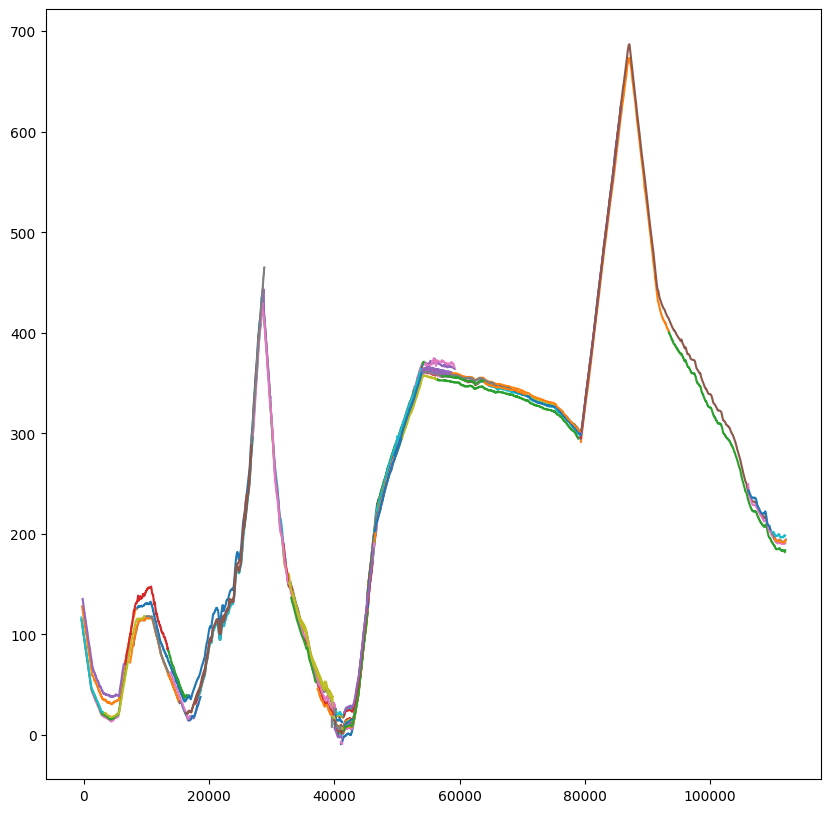

In [42]:
plt.rcParams['figure.figsize']=(10,10)
t1=time.time()
corrected_meta_segments=realign_meta_segments_from_tree(shift_tree,meta_segments,min_tree_components=1)
corrected_meta_segments+=[meta_segments[k] for k in affine_meta_segments]
t2=time.time()
print(t2-t1)
for meta_segment in corrected_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])



In [43]:
cover,extremities=get_cover(corrected_meta_segments,min_count=2)
len(cover)

1

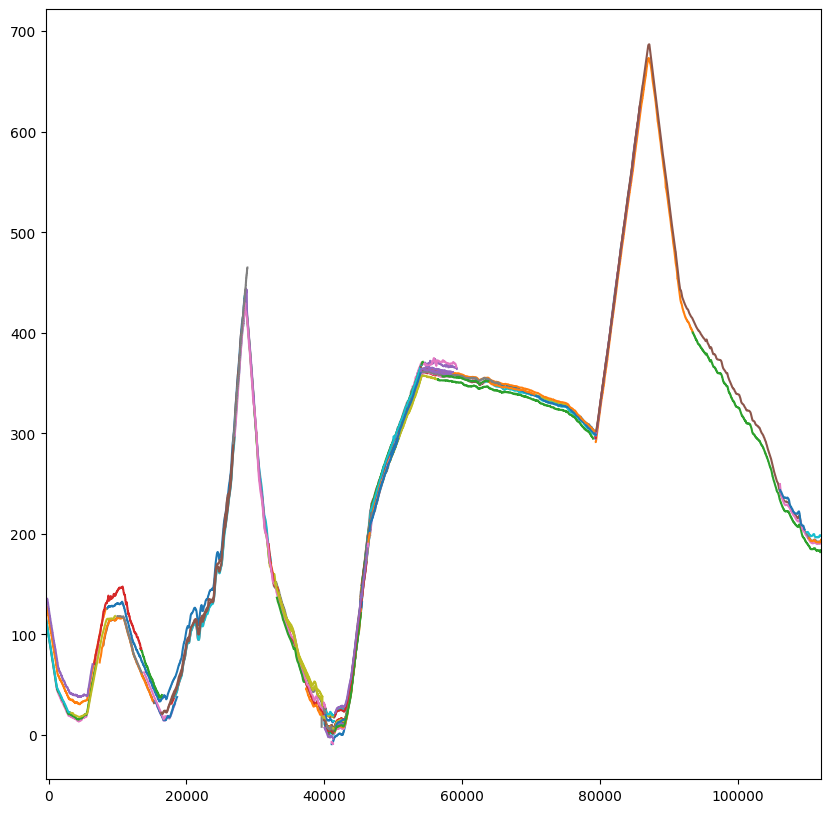

In [44]:
i=0
sub_meta_segments=[corrected_meta_segments[k] for k in cover[i]]
x_min,x_max=extremities[i]
plt.xlim(x_min,x_max)
for meta_segment in sub_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])    


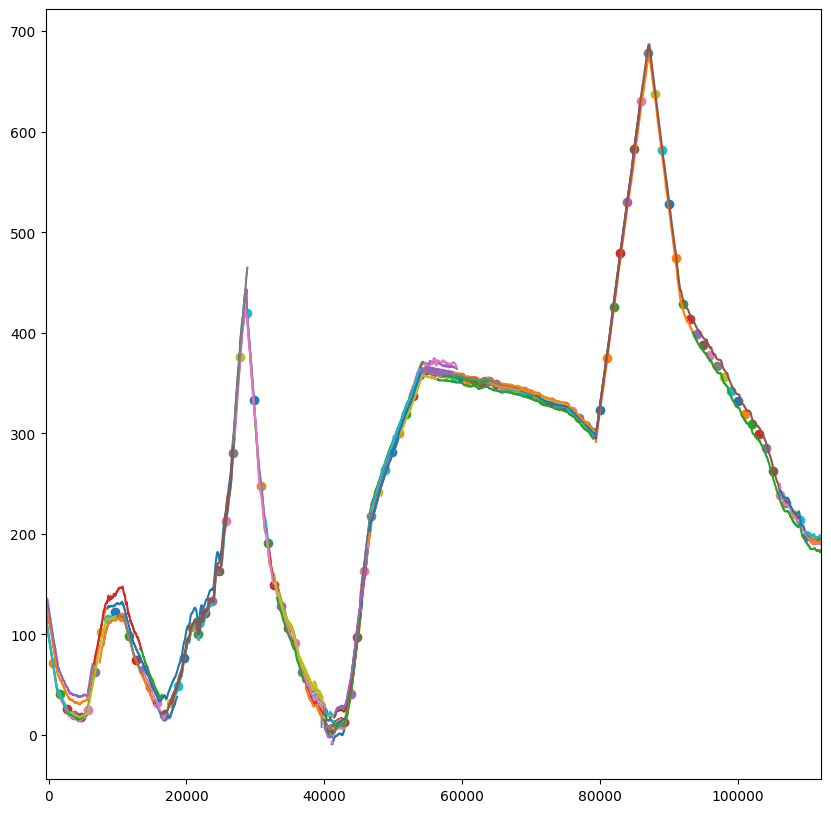

In [45]:
plt.xlim(x_min,x_max)
intermediate_distance=1000
intermediate_points=np.linspace(x_min,x_max,max(round((x_max-x_min)/intermediate_distance)+1,2))
for meta_segment in sub_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y']) 
intermediate_elevations=get_intermediate_elevation(intermediate_points,sub_meta_segments)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))

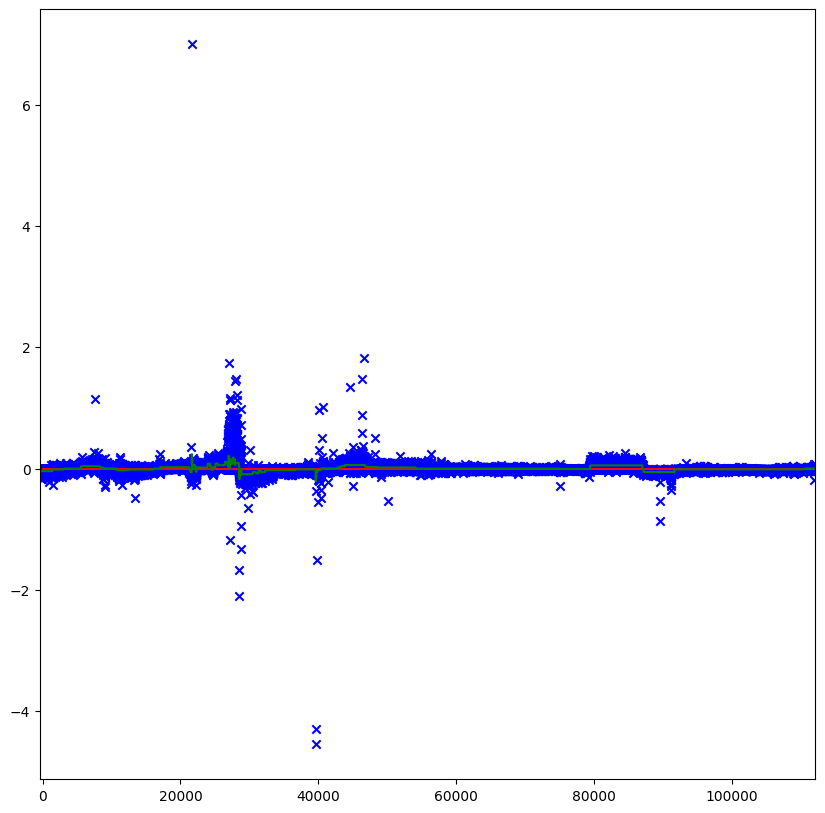

In [46]:
plt.xlim(x_min,x_max)
output=approximate_derivative(sub_meta_segments,x_min=x_min,x_max=x_max,
                                    min_samples_leaf=25,min_impurity_decrease=0.5*float('1e-6'))
if output is not None:
    X,dYdX,model=output
    Z=model.predict(X.reshape(-1,1))
    plt.scatter(X,dYdX,c='b',marker='x')
    plt.plot([0,X[-1]],[0,0],c='r')
    plt.plot(X,Z,c='g')


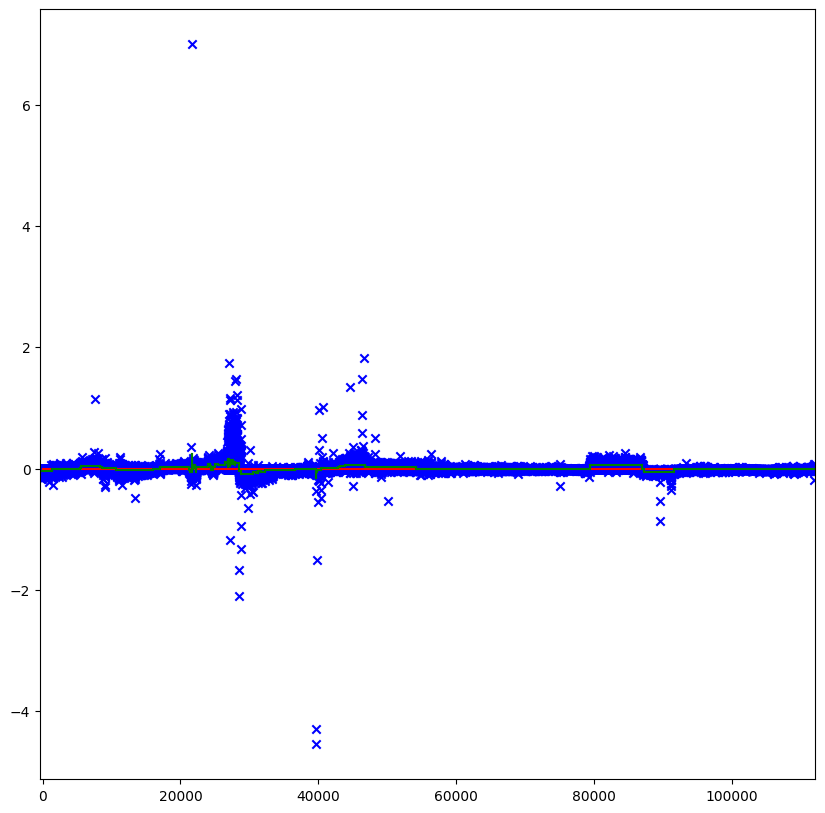

In [47]:
plt.xlim(x_min,x_max)
intervals=simplify_tree(model.tree_,x_min,x_max,min_interval_size=100.)
plt.scatter(X,dYdX,c='b',marker='x')
plt.plot([0,X[-1]],[0,0],c='r')
for x1,x2,v in intervals:
    plt.plot([x1,x2],[v,v],c='g')
for k in range(len(intervals)-1):
    _,x1,v1=intervals[k]
    x2,_,v2=intervals[k+1]
    plt.plot([x1,x2],[v1,v2],c='g')

39.315379 m elevation difference on a 112.389078 kms long path


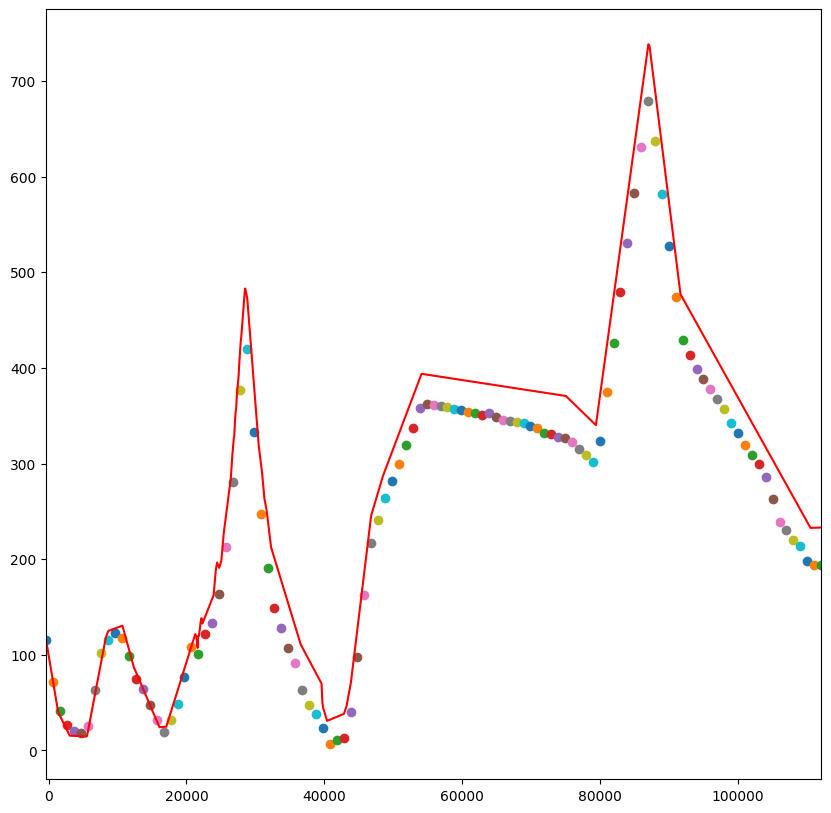

In [48]:
plt.xlim(x_min,x_max)
XX,YY=infer_curve_from_estimated_gradient(intervals,np.nanmedian(intermediate_elevations[0]))

plt.plot(XX,YY,c='r')
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
print('%f m elevation difference on a %f kms long path'%(YY[-1]-np.nanmedian(intermediate_elevations[-1]),(x_max-x_min)/1000))

total error 340.980409:


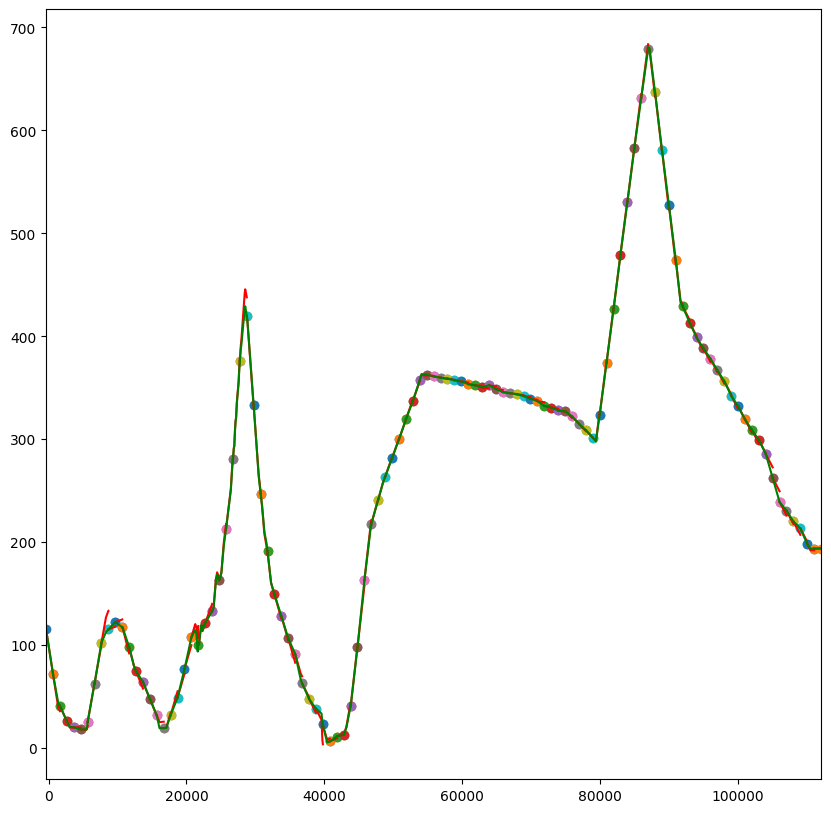

In [49]:
plt.xlim(x_min,x_max)
s=0
for k in range(len(intermediate_points)-1):
    sub_intervals=[[min(max(x1,intermediate_points[k]),intermediate_points[k+1]),min(max(x2,intermediate_points[k]),intermediate_points[k+1]),v] for x1,x2,v in intervals if x2>=intermediate_points[k] and x1<=intermediate_points[k+1]]
    XX,YY=infer_curve_from_estimated_gradient(sub_intervals,np.nanmedian(intermediate_elevations[k]))
    plt.plot(XX,YY,c='r')
    delta_expected=np.nanmedian(intermediate_elevations[k+1])-np.nanmedian(intermediate_elevations[k])
    YY,delta=adjust_curve_elevation(YY,delta_expected)
    s+=abs(delta-delta_expected)
    plt.plot(XX,YY,c='g')

    
    plt.scatter([intermediate_points[k],intermediate_points[k+1]],[np.nanmedian(intermediate_elevations[k]),np.nanmedian(intermediate_elevations[k+1])])
print('total error %f:'%s)

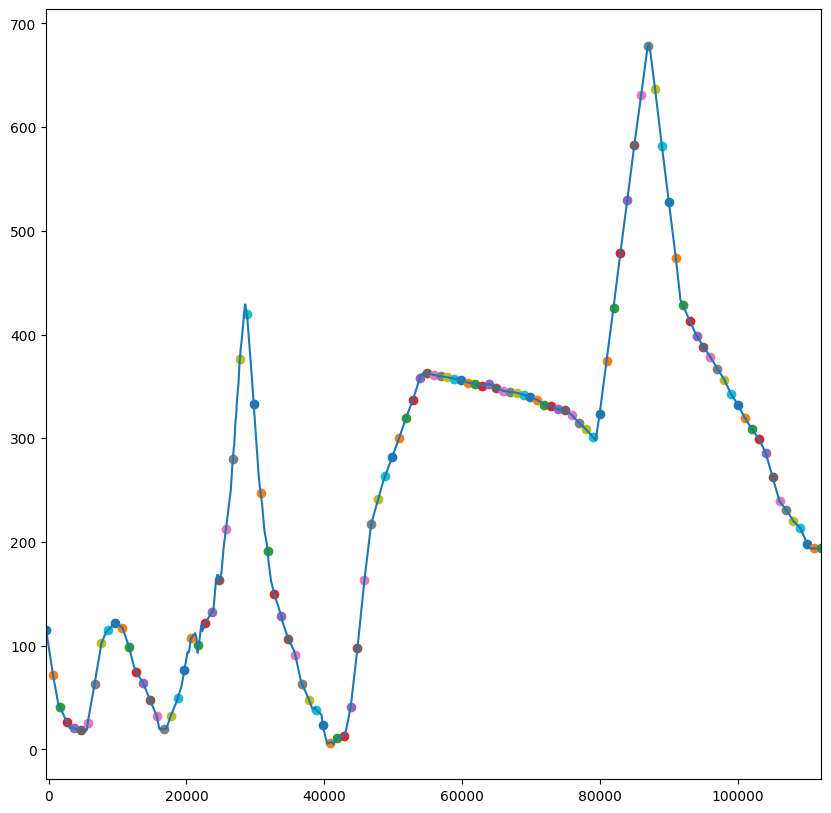

In [50]:
plt.xlim(x_min,x_max)
X,Y=approximate_elevation_profile(sub_meta_segments,x_min,x_max,intermediate_distance=1000)
X,Y=np.array(X),np.array(Y)
plt.plot(X,Y)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
    


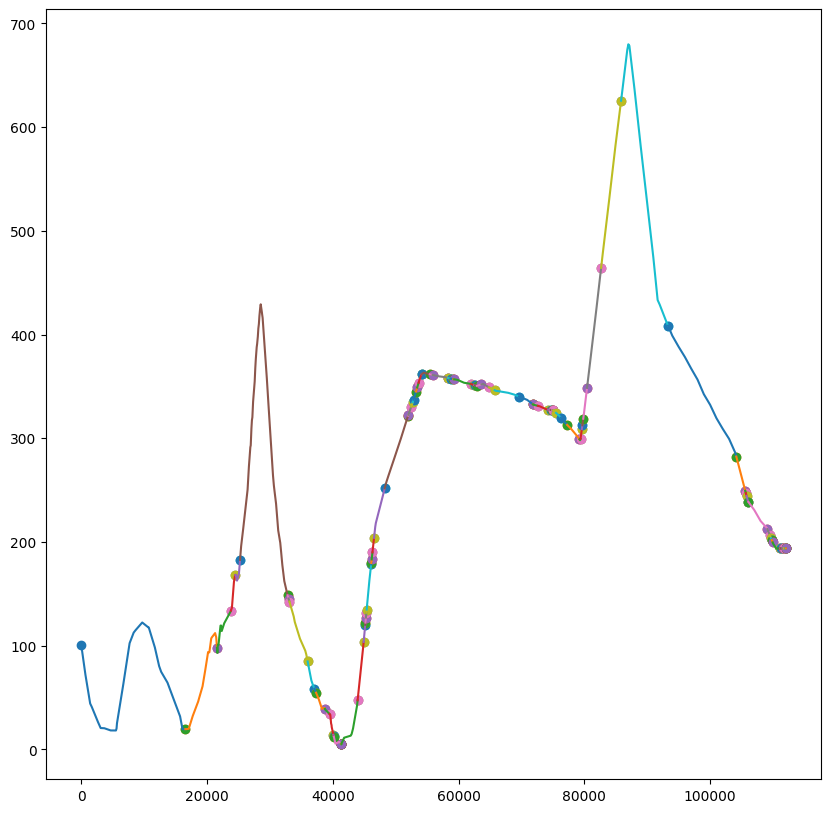

In [51]:
nodes_data,edges_data=collect_elevation_information_from_sub_meta_segments(path,nodes_positions,sub_meta_segments,x_min,x_max)

for k,edge in enumerate(path):
    if edge in edges_data:
        L=edges_data[edge]
        for elem in L:
            plt.plot(nodes_positions[k]+elem['X'],elem['Y'])
    if edge[0] in nodes_data:
        plt.scatter(nodes_positions[k],nodes_data[edge[0]])
    if edge[1] in nodes_data:
        plt.scatter(nodes_positions[k+1],nodes_data[edge[1]])            

